In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft2, ifft2
from scipy.optimize import minimize
from sklearn import datasets

Consider retrieving $x \in \mathbb{C}^n$ from measurements

$$y = \mathcal{A}(x) + \epsilon,$$

by solving

$$\min_z J(z), \quad J(z)  = \|\mathcal{A}\circ \mathcal{G} (z) - y\|_2^2 + \lambda^2\|z\|_2^2,$$

where $\mathcal{G}$ is a generative model.

The gradient of $J$ is given by

$$\nabla J(z) = \left(\mathcal{G}'(z)\right)^*\left(\mathcal{A}'(x)\right)^*\left(\mathcal{A}\circ \mathcal{G} (z) - y\right),$$

with $x = \mathcal{G}(z)$ and $\mathcal{G}'(z)$ the Jacobian of $\mathcal{G}$ and $\mathcal{A}'(x)$ the Jacobian of $\mathcal{A}$. 

We typically consider 

$$\mathcal{A}(x) = |Ax|^2,$$

for some given matrix $A \in \mathbb{C}^{m\times n}$. In that case we have

$$\mathcal{A}'(x) = 2\text{diag}(Ax)\overline{A}.$$

We take $A$ to be a masked Fourier transform, in which case it is given by

$$A = \left(\begin{matrix} FM_1 \\ FM_2 \\ \vdots \\ FM_m\end{matrix}\right),$$

with $F \in \mathbb{C}^{n\times n}$ the 2D Fourier transform and $M_i \in \mathbb{C}^{n\times n}$ a diagonal matrix containing a mask.

A simple generative model can be obtained as

$$\mathcal{G}(z) = \mu + Sz, $$

with $\mu$ the mean of the training samples, and $S$ a Cholesky factorisation of the sample covariance matrix (i.e., $\Sigma = SS^*$.)

We can also let $\mathcal{G}(z) = z$ and $\mathcal{G}(z) = \mu + Sz_1 + z_2$.

### Main functions

In [27]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)
    
    yp = A.eval(xc)
    Dy = A.jac(xc)

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc

    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    result = minimize(objective, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True, options={
        'maxiter': 10000,      # total outer iterations
        'maxls': 40,          # line search steps per iteration
        'ftol' : 1e-14,
        'gtol': 1e-14,         # gradient tolerance
        'disp': True          # print optimization log
    })
    
    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)
    
    # correct global phase
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs, zhat # note before this was result

def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

### Dataset

In [3]:
# load data set of 3's (8 x 8, 183 images)
(digits, cls) = datasets.load_digits(return_X_y=True)
X = np.ones((183, 64)) + 1j*digits[np.where(cls==3)[0],:]/16

n = X.shape[1]
nx = int(np.sqrt(n))

In [2]:
# load data set of 3's (10 x 10, 6131 images)
X = np.load('MNIST_100_only3_train.npy')
dataset_size = X.shape[0]
X = X.reshape((dataset_size, -1))

n = X.shape[1]
nx = int(np.sqrt(n))

print(X.shape)

# verification images
X_test = np.load('MNIST_100_only3_test.npy')
test_size = X_test.shape[0]
X_test = X_test.reshape((test_size, -1))

(6131, 100)


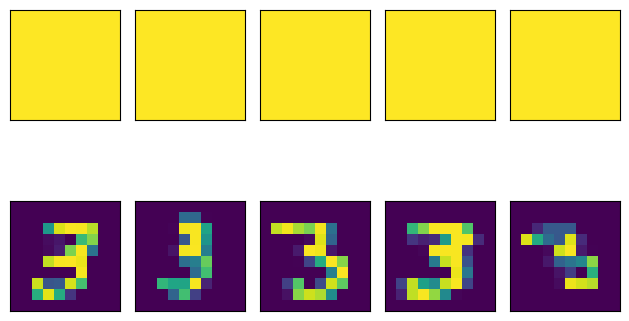

In [29]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = X[i]
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

plt.savefig('example1_data.png',dpi=300)

### Operators

In [30]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv)
    
    return A

In [31]:
# get prior
mu    = np.mean(X,axis=0)
Sigma = np.conj((X-mu).T)@(X-mu)/X.shape[0]
s, U = np.linalg.eigh(Sigma + 1e-6*np.eye(n))

k = 10
B = U[:,-k:]@np.diag(np.sqrt(s[-k:]))

C = np.concatenate((np.real(B), np.eye(n)), axis=1)

# define generative models
G = Op(fun = lambda z : mu + B@z, jac = lambda z : LinearOperator((n, k), matvec = lambda z : B@z, rmatvec = lambda z : np.conj(B.T)@z), shape=(n,k))
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))
H = Op(fun = lambda z : mu + C@z, jac = lambda z : LinearOperator((n, k+n), matvec = lambda z : C@z, rmatvec = lambda z : np.conj(C.T)@z), shape=(n,k+n))

# define weights
w = 1

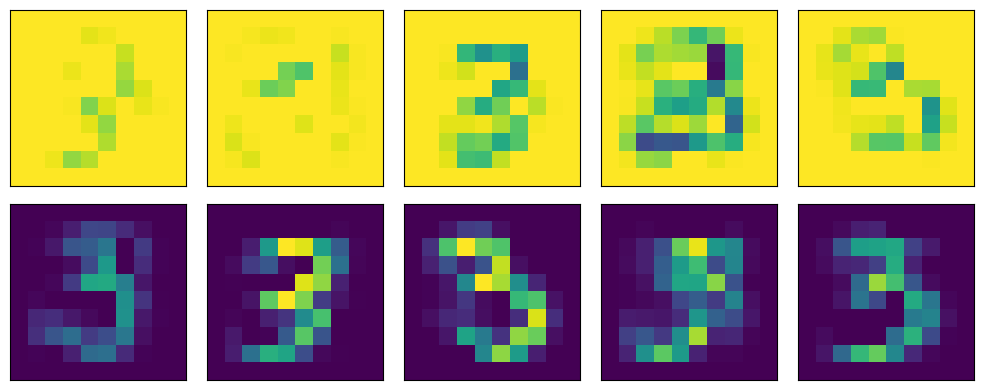

In [ ]:
ns = 5
fig, ax = plt.subplots(2,ns, figsize=(10,4))

for i in range(ns):
    z = np.random.randn(k) + 1j*np.random.randn(k)
    x = G.eval(z)
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

fig.subplots_adjust(hspace=0.1)

plt.savefig('example1_generative.png',dpi=300)

In [32]:
# define forward operator
mx = 100
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

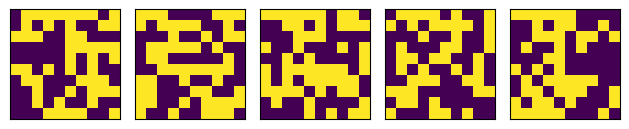

In [25]:
# plot some of the masks
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    ax[i].imshow(M[:,:,i],clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

plt.savefig('example1_masks.png',dpi=300)

3.287283109797299e-07


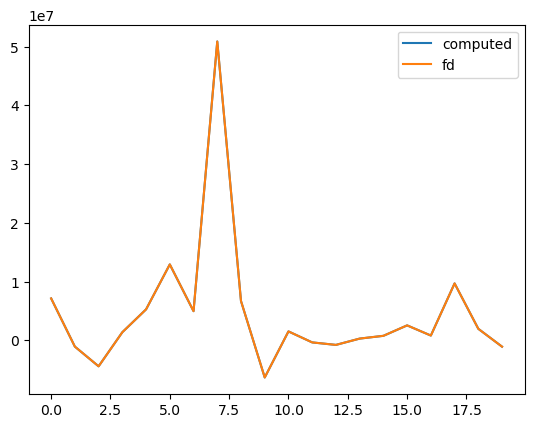

In [10]:
# gradient test
h = 1e-8

k  = G.shape[1]
zt = np.random.randn(2*k)
yt = np.random.randn(A.shape[0])

obj = lambda z : objective(z, yt, A, G)

val, grad = obj(zt)

grad_fd = np.zeros(2*k)
for i in range(2*k):
    e = np.zeros(2*k)
    e[i] = 1
    
    grad_fd[i] = (obj(zt+h*e)[0] - obj(zt-h*e)[0])/(2*h)

print(np.linalg.norm(grad_fd - grad) / np.linalg.norm(grad))

plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

### Experiments

#### Reconstruction error for varying measurement noise

In [ ]:
# scan over noise levels with and without generative model on in-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    for j in range(ns):
        #ztrue = np.random.randn(k) + 1j*np.random.randn(k) # normal
        ztrue = np.random.uniform(0,2,k) + 1j*np.random.uniform(0,2,k) # uniform
        
        xtrue = G.eval(ztrue)

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

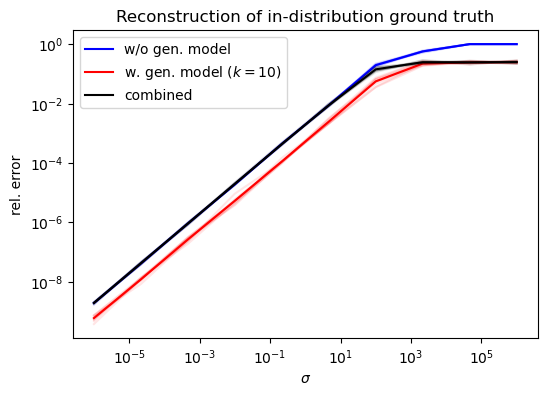

In [ ]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('Reconstruction of in-distribution ground truth')
ax.legend()

plt.savefig('MNIST_100_PCA_indistribution.png', dpi=300)

In [9]:
# scan over noise levels with and without generative model on out-of-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    for j in range(ns):
        xtrue = X_test[np.random.randint(0,X_test.shape[0])]

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

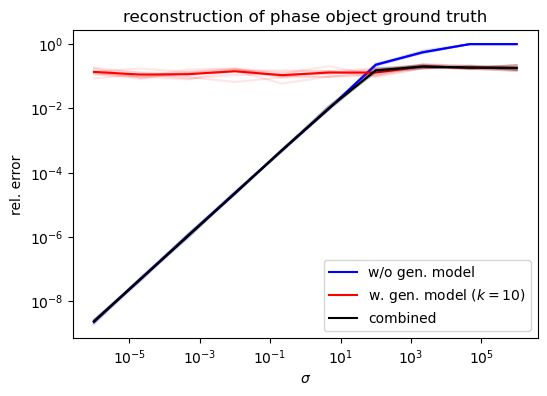

In [ ]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of phase object ground truth')

ax.legend()

plt.savefig('MNIST_100_PCA_outdistribution.png', dpi=300)

#### Bias for varying model discrepancy

In [12]:
## bias localized
def generate_noise(n, eta, noise_type="spread", num_localized=None, seed=None):
    """
    Generate noise with the same norm for both spread out and localized noise, ensuring reproducibility with a seed.

    Parameters:
    - n             = int, number of measurements
    - eta           = float, noise standard deviation
    - noise_type    = str, either "spread" or "localized"
    - num_localized = int, number of entries to have noise (only for "localized" type)
    - seed          = int, optional random seed for reproducibility

    Returns:
    - noise         = np.ndarray, noise vector of shape (n,)
    """
    if seed is not None:
        np.random.seed(seed) # generate local seed

    # generate spread noise
    spread_noise = eta * np.random.randn(n)
    spread_norm = np.linalg.norm(spread_noise)

    if noise_type == "spread":
        return spread_noise  
    
    elif noise_type == "localized":
        if num_localized is None:
            num_localized = max(1, n // 4)  #default: 25% of entries affected
        
        noise = np.zeros(n)
        #indices = np.random.choice(n, num_localized, replace=False)  # uncomment if want to select noise locations randomly
        index = np.random.randint(0,n-(num_localized-1), dtype=int) # select random first index for noise
        localized_noise = eta * np.random.randn(num_localized)  # generate localized noise gaussian

        # normalize to match spread-out noise norm
        localized_norm = np.linalg.norm(localized_noise)
        if localized_norm > 0:
            localized_noise *= spread_norm / localized_norm  # scale noise to match spread norm entrywise

        noise[index:(index+num_localized)] = localized_noise # add noise to correct entries
        return noise
    
    else:
        raise ValueError("Invalid noise_type. Choose 'spread' or 'localized'.")

In [ ]:
## bias experiments
# different samples for computing bias as the z0-term for in and out-distribution
ns     = 10

errors_in = np.zeros(ns)
xhats_in  = np.zeros((ns, n),dtype='complex')

errors_out = np.zeros(ns)
xhats_out  = np.zeros((ns, n),dtype='complex')

# averages
for j in range(ns):
    x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
    x_out = X_test[np.random.randint(0,X_test.shape[0])]

    errors_in[j], xhats_in[j,:], _, _ = reconstruct(x_in, I, G, w=1, sigma=0, lmbda=0)
    errors_out[j], xhats_out[j,:], _, _ = reconstruct(x_out, I, G, w=1, sigma=0, lmbda=0)

print(f"%Mean bias in-distr {np.mean(errors_in):.8e}  |  Std dev {np.std(errors_in):.6e}")
print(f"%Mean bias out-distr {np.mean(errors_out):.8e}  |  Std dev {np.std(errors_out):.6e}")

%Mean bias in-distr 2.61136878e-09  |  Std dev 1.527592e-09
%Mean bias out-distr 1.15044213e-01  |  Std dev 1.395550e-02


In [13]:
## bias experiments
# different samples for computing bias as the z0-term for in-distribution and varying its misspecification
ns     = 10
etas = np.logspace(-6,6,10)
num_loc = n // 10

bias_in = np.zeros((len(etas),ns))
xhats_in  = np.zeros((len(etas),ns, n),dtype='complex')

for i in range(len(etas)):
    for j in range(ns):
        x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
        art = generate_noise(n, etas[i], noise_type="spread", num_localized=num_loc, seed=None)
        x_pert = x_in + art
        
        bias_in[i,j], xhats_in[i,j,:], y_obs_in, _ = reconstruct(x_pert, I, G, w=1, sigma=0, lmbda=0)

for i in range(len(etas)):
    print(f"For eta level {etas[i]:.8e}  |  Mean bias {np.mean(bias_in[i, :]):.6e}")

For eta level 1.00000000e-06  |  Mean bias 9.058071e-07
For eta level 2.15443469e-05  |  Mean bias 2.005638e-05
For eta level 4.64158883e-04  |  Mean bias 4.246652e-04
For eta level 1.00000000e-02  |  Mean bias 9.193014e-03
For eta level 2.15443469e-01  |  Mean bias 1.897702e-01
For eta level 4.64158883e+00  |  Mean bias 9.555927e-01
For eta level 1.00000000e+02  |  Mean bias 9.639177e-01
For eta level 2.15443469e+03  |  Mean bias 9.520102e-01
For eta level 4.64158883e+04  |  Mean bias 9.649792e-01
For eta level 1.00000000e+06  |  Mean bias 9.405090e-01


In [37]:
## bias experiments
# different samples for computing bias as the z0-term for in-distribution and varying its misspecification
ns2     = 10
etas2 = np.logspace(-3,3,6)
num_loc2 = n // 20

bias_in2 = np.zeros((len(etas2),ns2))
bias_unnormalized2 = np.zeros((len(etas2),ns2))
z_differences2 = np.zeros((len(etas2),ns2))
xhats_in2  = np.zeros((len(etas2),ns2, n),dtype='complex')
zhats_in2  = np.zeros((len(etas2),ns2, k),dtype='complex')

ztrue_in2 = np.zeros((len(etas2),ns2,k), dtype='complex')

for i in range(len(etas2)):
    for j in range(ns2):
        ztrue2 = np.random.randn(k) + 1j*np.random.randn(k) #normal
        ztrue_in2[i,j,:] = ztrue2

        x_in2 = G.eval(ztrue2)
        art = etas2[i]*(np.random.randn(n)+1j*np.random.randn(n)) # normal

        art = generate_noise(n, etas2[i], noise_type="spread", num_localized=num_loc, seed=None)
        x_pert2 = x_in2 + art

        bias_in2[i,j], xhats_in2[i,j,:], y_obs_in2, zhats_in2[i,j,:] = reconstruct(x_pert2, I, G, w=1, sigma=0, lmbda=0)

        z_differences2[i,j]= np.linalg.norm(zhats_in2[i,j,:] - ztrue_in2[i,j,:])/np.linalg.norm(ztrue_in2[i,j,:])
        bias_unnormalized2[i,j] = bias_in2[i,j]*np.linalg.norm(x_pert2)

print(f"%Mean bias in-distr {np.mean(bias_in2):.6e}  |  Std dev {np.std(bias_in2):.6e}")

%Mean bias in-distr 5.148588e-01  |  Std dev 4.427373e-01


Text(0.5, 1.0, 'least squares minimization with prior (PCA)')

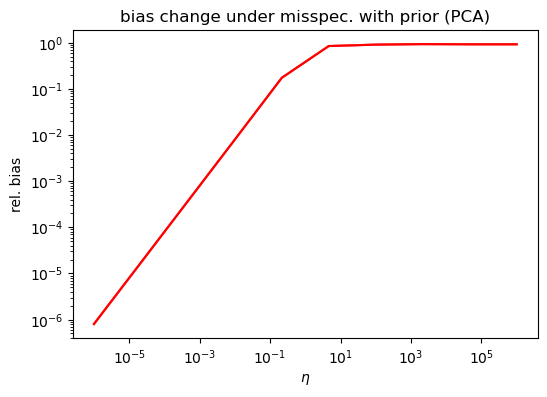

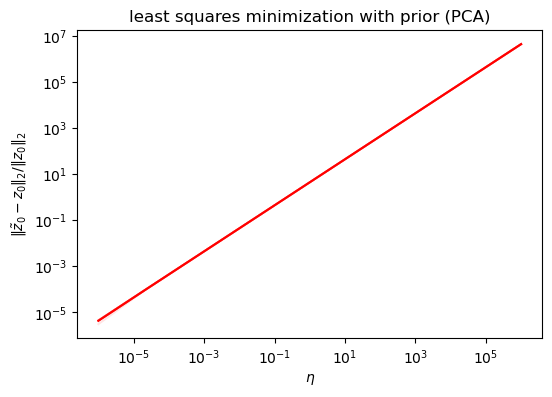

In [ ]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(etas2, np.mean(bias_in2,axis=1), 'r')
ax.loglog(etas2, bias_in2, 'r', alpha=1/ns)

ax.set_xlabel(r'$\eta$')
ax.set_ylabel('rel. bias')
ax.set_title('bias change under misspec. with prior (PCA)')

fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(etas2, np.mean(z_differences2,axis=1), 'r')
ax.loglog(etas2, z_differences2, 'r', alpha=1/ns)

ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax.set_title(r'least squares minimization with prior (PCA)')

#### Combined bias

In [ ]:
# different samples for computing bias as the zhat-term for in and out-distribution of the H-term
ns     = 10

errors_in = np.zeros(ns)
bias_in = np.zeros(ns)
xhats_in  = np.zeros((ns, n),dtype='complex')

errors_out = np.zeros(ns)
bias_out = np.zeros(ns)
xhats_out  = np.zeros((ns, n),dtype='complex')

for j in range(ns):
    x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
    x_out = X_test[np.random.randint(0,X_test.shape[0])]

    errors_in[j], xhats_in[j,:], _, result_in = reconstruct(x_in, I, H, w=1, sigma=0, lmbda=1)
    errors_out[j], xhats_out[j,:], _, result_out = reconstruct(x_out, I, H, w=1, sigma=0, lmbda=1)

    x1x2_in = result_in.x[:k+n] + 1j*result_in.x[k+n:]
    x2_in = x1x2_in[k:]
    G_z_temp = xhats_in[j,:] - x2_in
    phi = np.mean(np.angle(x_in/G_z_temp)) # angle correction outside of reconstruct function
    G_z_in = np.exp(1j*phi)*G_z_temp
    bias_in[j] = np.linalg.norm(G_z_in - x_in)/np.linalg.norm(x_in)

    x1x2_out = result_out.x[:k+n] + 1j*result_out.x[k+n:]
    x2_out = x1x2_out[k:]
    G_z_temp = xhats_out[j,:] - x2_out
    phi = np.mean(np.angle(x_out/G_z_temp)) 
    G_z_out = np.exp(1j*phi)*G_z_temp
    bias_out[j] = np.linalg.norm(G_z_out - x_out)/np.linalg.norm(x_out)

print(f"%Mean bias in-distr {np.mean(bias_in):.6e}  |  Std dev {np.std(bias_in):.6e}")
print(f"%Mean bias out-distr {np.mean(bias_out):.6e}  |  Std dev {np.std(bias_out):.6e}")

%Mean bias in-distr 1.768410e-01  |  Std dev 1.740407e-02
%Mean bias out-distr 1.728347e-01  |  Std dev 1.684668e-02


In [48]:
# different samples for computing bias as the zhat-term for IN-distribution of the H-term for different noise
etas = np.logspace(-3,3,6)
sigmas = np.logspace(-3,3,3)
ns     = 3 

errors_in   = np.zeros((len(etas),len(sigmas),ns))
bias_in_1   = np.zeros((len(etas),ns))                                # G(z0) - x0
bias_in_2   = np.zeros((len(etas),len(sigmas),ns))                    # G(ztilde) - x0
xhats_in    = np.zeros((len(etas),len(sigmas),ns,n),dtype='complex')
zcurly0_in  = np.zeros((len(etas),ns,k), dtype='complex')             #z_tilde0 from gen. approach
zcurly_in   = np.zeros((len(etas),len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach
ztrue_in    = np.zeros((len(etas),ns,k), dtype='complex')             #z0

z_diff_1    = np.zeros((len(etas),len(sigmas),ns))                    #||ztilde - ztilde0 ||
z_diff_2    = np.zeros((len(etas),len(sigmas),ns))                    #||ztilde - z0 ||

for i in range(len(etas)):
    print("i", i)
    for j in range(ns):
        print("j", j)
        ztrue = np.random.randn(k) + 1j*np.random.randn(k)
        ztrue_in[i,j,:] = ztrue

        x_in = G.eval(ztrue)
        art = etas[i]*(np.random.randn(n)+1j*np.random.randn(n)) # normal
        x_pert = x_in + art
         
        bias_in_1[i,j], _, _, zcurly0_in[i,j,:] = reconstruct(x_pert, I, G, w=1, sigma=0, lmbda=0)

        for l in range(len(sigmas)):
            print("l", l)
            errors_in[i,l,j], xhats_in[i,l,j,:], _, x1x2_in = reconstruct(x_pert, A, H, w=1, sigma=sigmas[l], lmbda=1e1*sigmas[l])

            x2_in = x1x2_in[k:]
            zcurly_in[i,l,j,:] = x1x2_in[:k]
            G_z_temp = xhats_in[i,l,j,:] - x2_in
            phi = np.mean(np.angle(x_pert/G_z_temp)) 
            G_z_in = np.exp(1j*phi)*G_z_temp

            bias_in_2[i,l,j] = np.linalg.norm(G_z_in - x_pert)/np.linalg.norm(x_pert)

            z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - zcurly0_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:]) 
            z_diff_2[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - ztrue_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:])

i 0
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2
i 1
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2
i 2
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2
i 3
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2
i 4
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2
i 5
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2


Text(0.5, 0.98, 'error latent vectors resulting from modelfitting (PCA)')

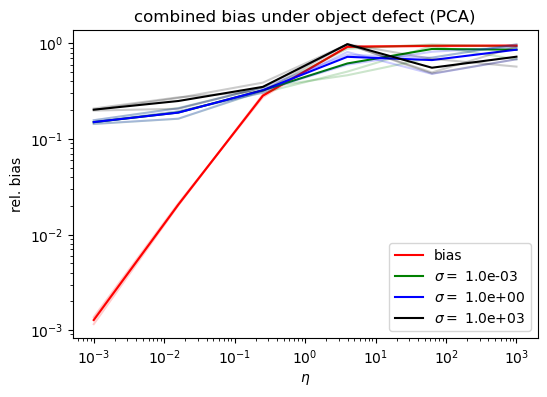

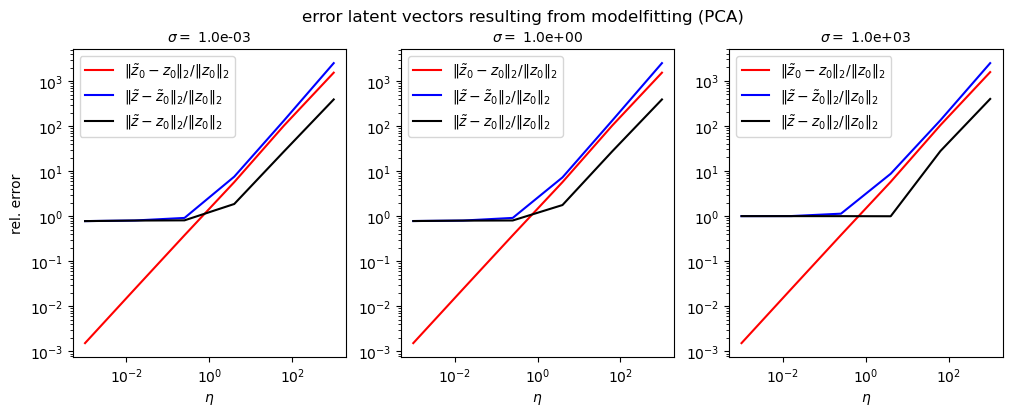

In [50]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(etas, np.mean(bias_in_1,axis=1), 'r', label=f'bias')
ax.loglog(etas, bias_in_1, 'r', alpha=1/5)

ax.loglog(etas, np.mean(bias_in_2[:,0,:],axis=1), 'g', label=fr'$\sigma =$ {sigmas[0]:.1e}')
ax.loglog(etas, bias_in_2[:,0,:], 'g', alpha=1/5)

ax.loglog(etas, np.mean(bias_in_2[:,1,:],axis=1), 'b', label=fr'$\sigma =$ {sigmas[1]:.1e}')
ax.loglog(etas, bias_in_2[:,1,:], 'b', alpha=1/5)

ax.loglog(etas, np.mean(bias_in_2[:,2,:],axis=1), 'k', label=fr'$\sigma =$ {sigmas[2]:.1e}')
ax.loglog(etas, bias_in_2[:,2,:], 'k', alpha=1/5)


ax.set_xlabel(r'$\eta$')
ax.set_ylabel('rel. bias')
ax.set_title('combined bias under object defect (PCA)')

ax.legend()

fig, ax = plt.subplots(1,3, figsize = (12,4))

ax[0].loglog(etas, np.mean(z_differences2, axis=1), 'r', label=r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax[0].loglog(etas, np.mean(z_diff_1[:,0,:],axis=1), 'b', label=r'$\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$')
ax[0].loglog(etas, np.mean(z_diff_2[:,0,:],axis=1), 'k', label=r'$\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$')
ax[0].set_title(fr'$\sigma =$ {sigmas[0]:.1e}', fontsize=10)
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel('rel. error')
ax[0].legend()

ax[1].loglog(etas, np.mean(z_differences2, axis=1), 'r', label=r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax[1].loglog(etas, np.mean(z_diff_1[:,1,:],axis=1), 'b', label=r'$\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$')
ax[1].loglog(etas, np.mean(z_diff_2[:,1,:],axis=1), 'k', label=r'$\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$')
ax[1].set_title(fr'$\sigma =$ {sigmas[1]:.1e}', fontsize=10)
ax[1].set_xlabel(r'$\eta$')
ax[1].legend()

ax[2].loglog(etas, np.mean(z_differences2, axis=1), 'r', label=r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax[2].loglog(etas, np.mean(z_diff_1[:,2,:],axis=1), 'b', label=r'$\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$')
ax[2].loglog(etas, np.mean(z_diff_2[:,2,:],axis=1), 'k', label=r'$\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$')
ax[2].set_title(fr'$\sigma =$ {sigmas[2]:.1e}', fontsize=10)
ax[2].set_xlabel(r'$\eta$')
ax[2].legend()

fig.suptitle('error latent vectors resulting from modelfitting (PCA)')

In [ ]:
# different samples for computing bias as the zhat-term for OUT-distribution of the H-term
etas = [1]
sigmas = np.logspace(-3,3,5) 
ns     = 5 # for testing

errors_in   = np.zeros((len(etas),len(sigmas),ns))
bias_in_1   = np.zeros((len(etas),ns))                                # G(z0) - x0
bias_in_2   = np.zeros((len(etas),len(sigmas),ns))                    # G(ztilde) - x0
xhats_in    = np.zeros((len(etas),len(sigmas),ns,n),dtype='complex')
zcurly0_in  = np.zeros((len(etas),ns,k), dtype='complex')             #z_tilde0 from gen. approach
zcurly_in   = np.zeros((len(etas),len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach

z_diff_1    = np.zeros((len(etas),len(sigmas),ns))                    #||ztilde - ztilde0 ||

for i in range(len(etas)):
    print("i", i)
    for j in range(ns):
        print("j", j)

        x_pert = X_test[np.random.randint(0,X_test.shape[0])]
        bias_in_1[i,j], _, _, zcurly0_in[i,j,:] = reconstruct(x_pert, I, G, w=1, sigma=0, lmbda=0)

        for l in range(len(sigmas)):
            print("l", l)
            errors_in[i,l,j], xhats_in[i,l,j,:], _, x1x2_in = reconstruct(x_pert, A, H, w=1, sigma=sigmas[l], lmbda=1)

            x2_in = x1x2_in[k:]
            zcurly_in[i,l,j,:] = x1x2_in[:k]
            G_z_temp = xhats_in[i,l,j,:] - x2_in
            phi = np.mean(np.angle(x_pert/G_z_temp)) 
            G_z_in = np.exp(1j*phi)*G_z_temp

            bias_in_2[i,l,j] = np.linalg.norm(G_z_in - x_pert)/np.linalg.norm(x_pert)

            z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - zcurly0_in[i,j,:])/np.linalg.norm(zcurly0_in[i,j,:]) 

j 0
l 0
l 1
l 2
l 3
l 4
j 1
l 0
l 1
l 2
l 3
l 4
j 2
l 0
l 1
l 2
l 3
l 4
j 3
l 0
l 1
l 2
l 3
l 4
j 4
l 0
l 1
l 2
l 3
l 4


#### Split modelfitting and datafitting term

In [44]:
# split in a datafitting term and a modelfitting term, IN distribution
ns     = 5
sigmas = np.logspace(-6,6,10)
eta    = 1e-3

errors_c    = np.zeros((len(sigmas),ns))
xhats_c     = np.zeros((len(sigmas),ns, n),dtype='complex')
bias_in_h   = np.zeros((len(sigmas),ns))
modelfit_h  = np.zeros((len(sigmas),ns))
modelfit_h_lam   = np.zeros((len(sigmas),ns))

datafit_h   = np.zeros((len(sigmas),ns))

bias_in_1   = np.zeros((len(sigmas),ns))                    # G(z0) - x0

zcurly_in   = np.zeros((len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach
ztrue_in    = np.zeros((len(sigmas),ns,k), dtype='complex')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        print("j:", j)
        ztrue = np.random.randn(k) + 1j*np.random.randn(k) # normal
        ztrue_in[i,j,:] = ztrue

        #ztrue = np.random.uniform(0,2,k) + 1j*np.random.uniform(0,2,k) # uniform
        x_in = G.eval(ztrue) 
        art = eta*(np.random.randn(n)+1j*np.random.randn(n)) 
        xtrue = x_in + art
         
        bias_in_1[i,j], _, _, _ = reconstruct(xtrue, I, G, w=1, sigma=0, lmbda=0)

        errors_c[i,j], xhats_c[i,j,:], yobs_in, x1x2_in = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=10*sigmas[i])

        x2_in = x1x2_in[k:]
        zcurly_in[i,j,:] = x1x2_in[:k]
        G_z_temp = xhats_c[i,j,:] - x2_in
        phi = np.mean(np.angle(xtrue/G_z_temp)) 
        G_z_in = np.exp(1j*phi)*G_z_temp

        bias_in_h[i,j] = np.linalg.norm(G_z_in - xtrue)/np.linalg.norm(xtrue)
        modelfit_h[i,j] = np.linalg.norm(G_z_in - xhats_c[i,j,:])/np.linalg.norm(xtrue)
        modelfit_h_lam[i,j] = 10*sigmas[i]*np.linalg.norm(G_z_in - xhats_c[i,j,:])/np.linalg.norm(xtrue)

        datafit_h[i,j] = np.linalg.norm(A.eval(xhats_c[i,j,:]) - yobs_in)/np.linalg.norm(xtrue) 


i: 0
j: 0
j: 1
j: 2
j: 3
j: 4
i: 1
j: 0
j: 1
j: 2
j: 3
j: 4
i: 2
j: 0
j: 1
j: 2
j: 3
j: 4
i: 3
j: 0
j: 1
j: 2
j: 3
j: 4
i: 4
j: 0
j: 1
j: 2
j: 3
j: 4
i: 5
j: 0
j: 1
j: 2
j: 3
j: 4
i: 6
j: 0
j: 1
j: 2
j: 3
j: 4
i: 7
j: 0
j: 1
j: 2
j: 3
j: 4
i: 8
j: 0
j: 1
j: 2
j: 3
j: 4
i: 9
j: 0
j: 1
j: 2
j: 3
j: 4


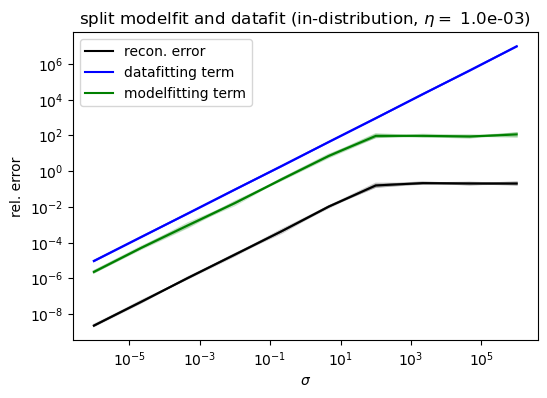

In [45]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='recon. error')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.loglog(sigmas, np.mean(datafit_h,axis=1), 'b', label='datafitting term')
ax.loglog(sigmas, datafit_h, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(modelfit_h_lam,axis=1), 'g', label='modelfitting term')
ax.loglog(sigmas, modelfit_h_lam, 'g', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title(rf'split modelfit and datafit (in-distribution, $\eta = $ {eta:.1e})')
ax.legend()


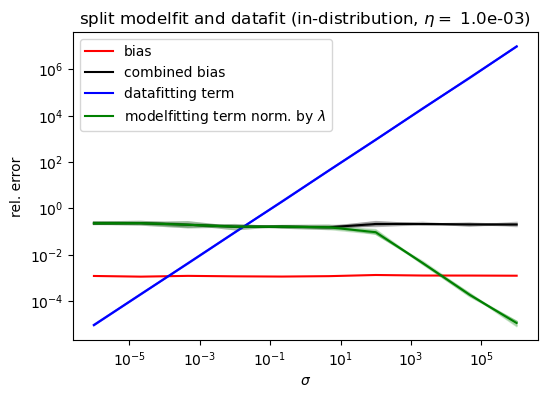

In [46]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, bias_in_1[:,1], 'r', label='bias')

ax.loglog(sigmas, np.mean(bias_in_h,axis=1), 'k', label='combined bias')
ax.loglog(sigmas, bias_in_h, 'k', alpha=1/ns)


ax.loglog(sigmas, np.mean(datafit_h,axis=1), 'b', label='datafitting term')
ax.loglog(sigmas, datafit_h, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(modelfit_h,axis=1), 'g', label=r'modelfitting term norm. by $\lambda$')
ax.loglog(sigmas, modelfit_h, 'g', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title(rf'split modelfit and datafit (in-distribution, $\eta = $ {eta:.1e})')
ax.legend()


In [ ]:
# split in a datafitting term and a modelfitting term, OUT distribution
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_c    = np.zeros((len(sigmas),ns))
xhats_c     = np.zeros((len(sigmas),ns, n),dtype='complex')
bias_out_h   = np.zeros((len(sigmas),ns))
modelfit_h  = np.zeros((len(sigmas),ns))
modelfit_h_lam   = np.zeros((len(sigmas),ns))

datafit_h   = np.zeros((len(sigmas),ns))

bias_out_1   = np.zeros((len(sigmas),ns))                    # G(z0) - x0

zcurly_out   = np.zeros((len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach

x_export = np.zeros((len(sigmas), ns, n), dtype='complex')

for i in range(len(sigmas)):
    print("i", i)
    for j in range(ns):
        print("j", j)
        xtrue = X_test[np.random.randint(0,X_test.shape[0])]

        errors_c[i,j], xhats_c[i,j,:], yobs_out, x1x2_out = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i]) 

        # compute G(ztilde)
        x2_out = x1x2_out[k:]
        zcurly_out[i,j,:] = x1x2_out[:k]
        G_z_temp = xhats_c[i,j,:] - x2_out
        phi = np.mean(np.angle(xtrue/G_z_temp)) 
        G_z_out = np.exp(1j*phi)*G_z_temp

        bias_out_h[i,j] = np.linalg.norm(G_z_out - xtrue)/np.linalg.norm(xtrue) # bias 2: G(ztilde) - x0
        modelfit_h[i,j] = np.linalg.norm(G_z_out - xhats_c[i,j,:])/np.linalg.norm(xtrue)  
        modelfit_h_lam[i,j] = 10*sigmas[i]*np.linalg.norm(G_z_in - xhats_c[i,j,:])/np.linalg.norm(xtrue)

        datafit_h[i,j] = np.linalg.norm(A.eval(xhats_c[i,j,:]) - yobs_out)/np.linalg.norm(xtrue)  
        
        bias_out_1[i,j], _, _, _ = reconstruct(xtrue, I, G, w=1, sigma=0, lmbda=0)

i: 0
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 1
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 2
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 3
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 4
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 5
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 6
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 7
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 8
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 9
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9


In [ ]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='recon. error')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.loglog(sigmas, np.mean(datafit_h,axis=1), 'b', label='datafitting term')
ax.loglog(sigmas, datafit_h, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(modelfit_h_lam,axis=1), 'g', label='modelfitting term')
ax.loglog(sigmas, modelfit_h_lam, 'g', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('split modelfit and datafit (out-of-distribution)')
ax.legend()

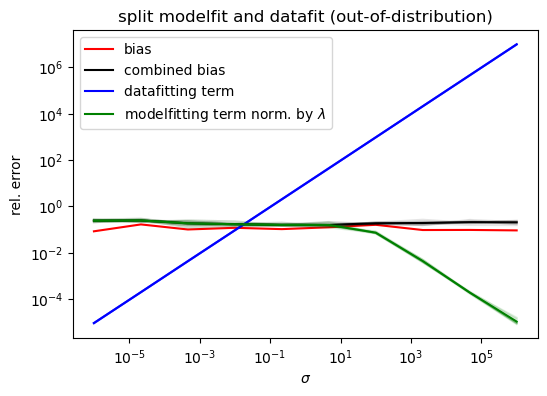

In [ ]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, bias_out_1[:,1], 'r', label='bias')

ax.loglog(sigmas, np.mean(bias_out_h,axis=1), 'k', label='combined bias')
ax.loglog(sigmas, bias_out_h, 'k', alpha=1/ns)

ax.loglog(sigmas, np.mean(datafit_h,axis=1), 'b', label='datafitting term')
ax.loglog(sigmas, datafit_h, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(modelfit_h,axis=1), 'g', label=r'modelfitting term norm. by $\lambda$')
ax.loglog(sigmas, modelfit_h, 'g', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('split modelfit and datafit (out-of-distribution)')
ax.legend()


#### Numerical estimate to Lipschitz constant

In [39]:
def Lipschitz_est(A, G, samp_amount):
    lip_const_list = []
    perturb_range = [10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
    k = G.shape[1]

    x_vals = np.linspace(-10,10,5)
    y_vals = np.linspace(-10,10,5)
    grid_points = [complex(x,y)*np.ones(k) for x in x_vals for y in y_vals]  # 25 total

    for x_lip in grid_points:
        for i in range(samp_amount):
            for j in perturb_range:
                perturb = np.random.normal(0,j,k) + 1j*np.random.normal(0,j,k)
                x_pert = np.linalg.norm(perturb)
                Func_pert = np.linalg.norm((A.eval(G.eval(x_lip)) - A.eval(G.eval(x_lip+perturb))))
                Lip = Func_pert / x_pert
                lip_const_list.append(Lip)

    return lip_const_list

In [40]:
# for G
lip_const_G = Lipschitz_est(I,G,100)
print(np.max(lip_const_G))
print(np.min(lip_const_G))

# for A
lip_const_A = Lipschitz_est(A,I,100)
print(np.max(lip_const_A))
print(np.min(lip_const_A))

# for A \circ G
lip_const_AG = Lipschitz_est(A,G,100)
print(np.max(lip_const_AG))
print(np.min(lip_const_AG))

0.7538833733943058
0.39638781223126696
24332.321004799684
0.0008691949114732864
3684.4569383459593
270.23876619254156
